# **Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Grupo ( A )

---


Aluna(o): Luana Guedes Barros Martins

---

Aluna(o): Ruan Chaves Rodrigues

---

Aluna(o): Thiago Monteles de Souza

---

# Atividade Prática 06 - Processamento de Linguagem Natural

Particionamento das atividades:
- Luana Guedes Barros Martins: Desenvolvedor
- Ruan Chaves Rodrigues: Analista de dados
- Thiago Monteles de Souza: Gerente do Projeto

In [1]:
!pip install gensim

In [2]:
!pip install spacy

In [3]:
!python -m spacy download pt_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [4]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Imports

from collections import defaultdict
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
import numpy as np

import pandas as pd
import spacy 
from collections import Counter
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

## Descrição do Problema

Utilizando as técnicas estudadas, será desenvolvido uma ferramenta que permita a comparação de pequenos textos. Devem ser definidas métricas de comparação que classifique os textos segundo critérios de similaridade.

A ferramenta deverá ser aplicada aos Estudos Dirigidos desenvolvidos ao longo do curso de Inteligência Artificial 2019-3. Para cada estudo, deve-se construir uma matriz que mostre a similaridade entre os documentos. Depois, definir um documento de referência e traçar um gráfico de similaridade dos demais em relação a ele.

## Tratamento dos Dados

In [6]:


def preprocess(source):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    nlp = spacy.load("pt_core_news_sm")
    docs = pd.read_csv(source, sep=";").fillna('o').astype(str).values.flatten().tolist()
    ids = pd.read_csv(source, sep=";").fillna('o').values
    ids = [ [(idx2, idx) for idx,v in enumerate(v2) ] for idx2,v2 in enumerate(ids) ]
    ids = [x for y in ids for x in y ]
    docs = [nlp(x) for x in docs]
    docs = [ [ y for y in x if y.is_punct == False and y.text.lower() not in stopwords] for x in docs ]
    tokens = [ [ y.lemma_.lower() for y in x ] for x in docs ]
    
    counter = dict(Counter([ x for y in tokens for x in y ]))
    low_freq = [x for x in counter.keys() if counter[x] == 1]
    tokens = [ [ x for x in y if x not in low_freq ] for y in tokens ]
    
    token_docs = [ ' '.join(x) for x in tokens ]
    mydict = corpora.Dictionary([simple_preprocess(line) for line in token_docs])
    
    corpus = [mydict.doc2bow(simple_preprocess(line)) for line in token_docs]
    
    return {
        "nlp": docs,
        "corpus" : corpus,
        "dict": mydict,
        "tokens": tokens,
        "ids" : ids
    }

## Definição do Modelo

In [7]:
def tfidf(preprocess_dict):
    corpus = preprocess_dict['corpus']
    mydict = preprocess_dict['dict']
    nf = len(mydict.dfs)
    tfidf = models.TfidfModel(corpus)
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=nf)
    return {
        "model" : tfidf,
        "index" : index
    }

def get_dataplot(preprocess_dict, model_dict):
    corpus = preprocess_dict['corpus']
    tfidf = model_dict['model']
    index = model_dict['index']
    dataplot = []
    for item in corpus:
        dataplot.append(index[tfidf[item]])
    return pd.DataFrame(dataplot)

def get_graph(preprocess_dict=None, dataplot=None, threshold=None, layout='spring', min_label=1):
    ids = preprocess_dict['ids']
    df = dataplot
    tmp = df.applymap(lambda x: 'nan' if x < threshold else x)
    arr = tmp.values.tolist()
    matches = []
    
    for idx, item in enumerate(arr):
        for idx2, item2 in enumerate(item):
            if idx != idx2 and arr[idx][idx2] != 'nan':
                matches.append([idx, idx2])
    pairs = [ [ ids[x][0] for x in y ] for y in matches ]
    
    dict_pairs = dict(Counter([ tuple(x) for x in pairs ])).items()
    G = nx.Graph()
    labels = {}
    percent = [ item[1] for item in dict_pairs ]
    percent_labels = [ str(x) for x in percent ]
    for idx,item in enumerate(dict_pairs):
        if percent[idx] < min_label:
            continue
        edge_in = ( str(item[0][0]), str(item[0][1]) )
        G.add_edge(*edge_in)
        labels[tuple(edge_in)] = percent_labels[idx]
    if layout == 'spring':
        pos = nx.spring_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    nx.draw(G, pos, node_size=500, with_labels=True)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=15, label_pos=0.5)

In [8]:
data_dict = preprocess("Dados - ED05.csv")

In [9]:
model_dict = tfidf(data_dict)

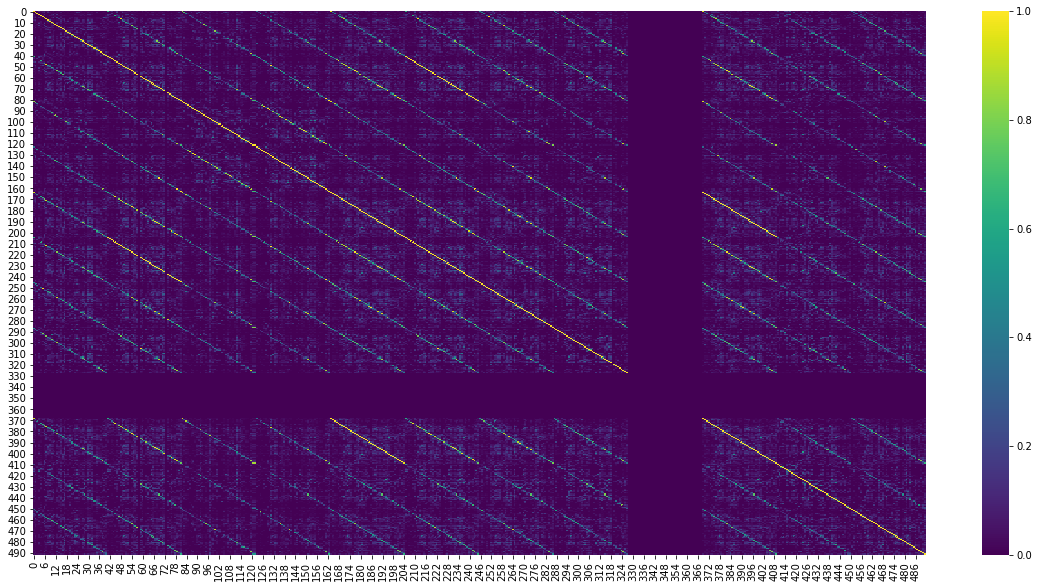

In [10]:
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(get_dataplot(data_dict, model_dict), cmap='viridis')

/run/media/user/DADOS/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


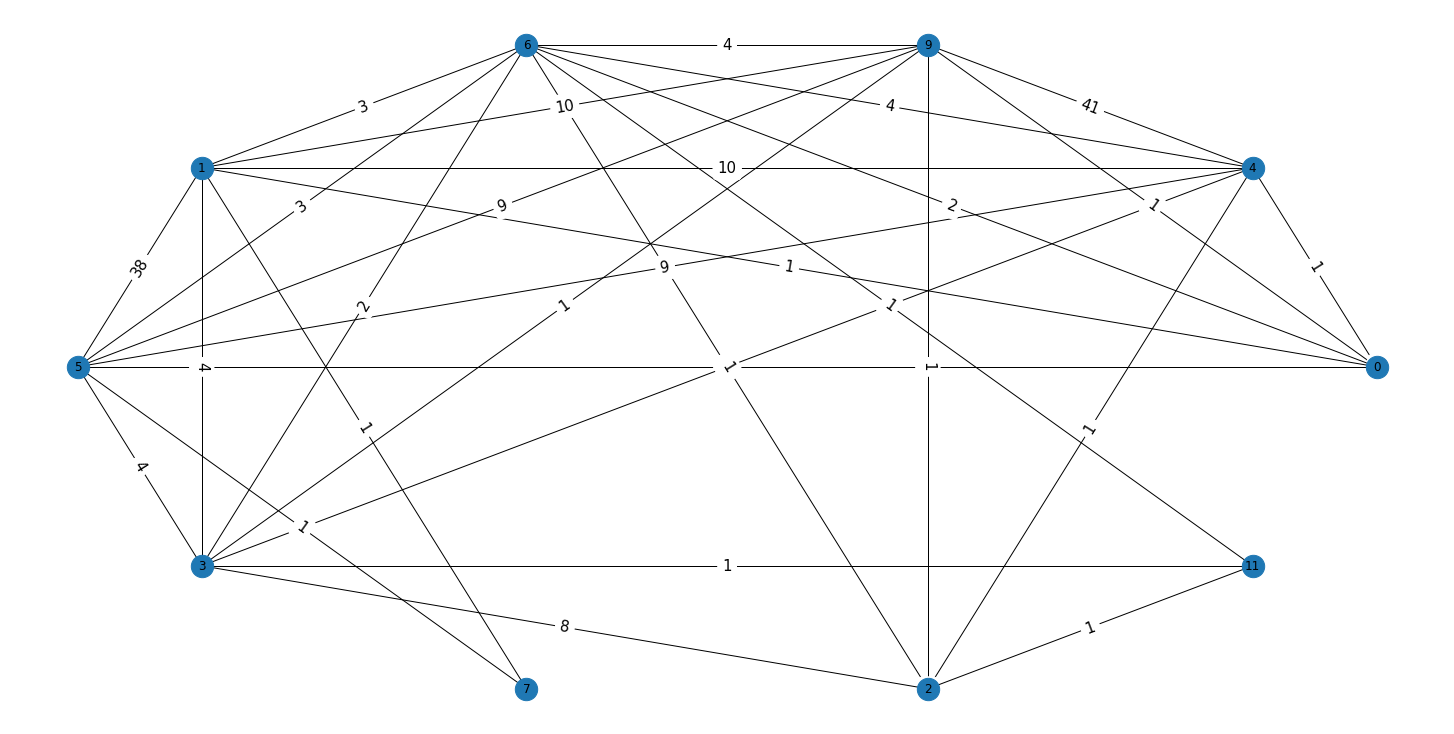

In [11]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9,
         layout='circular')

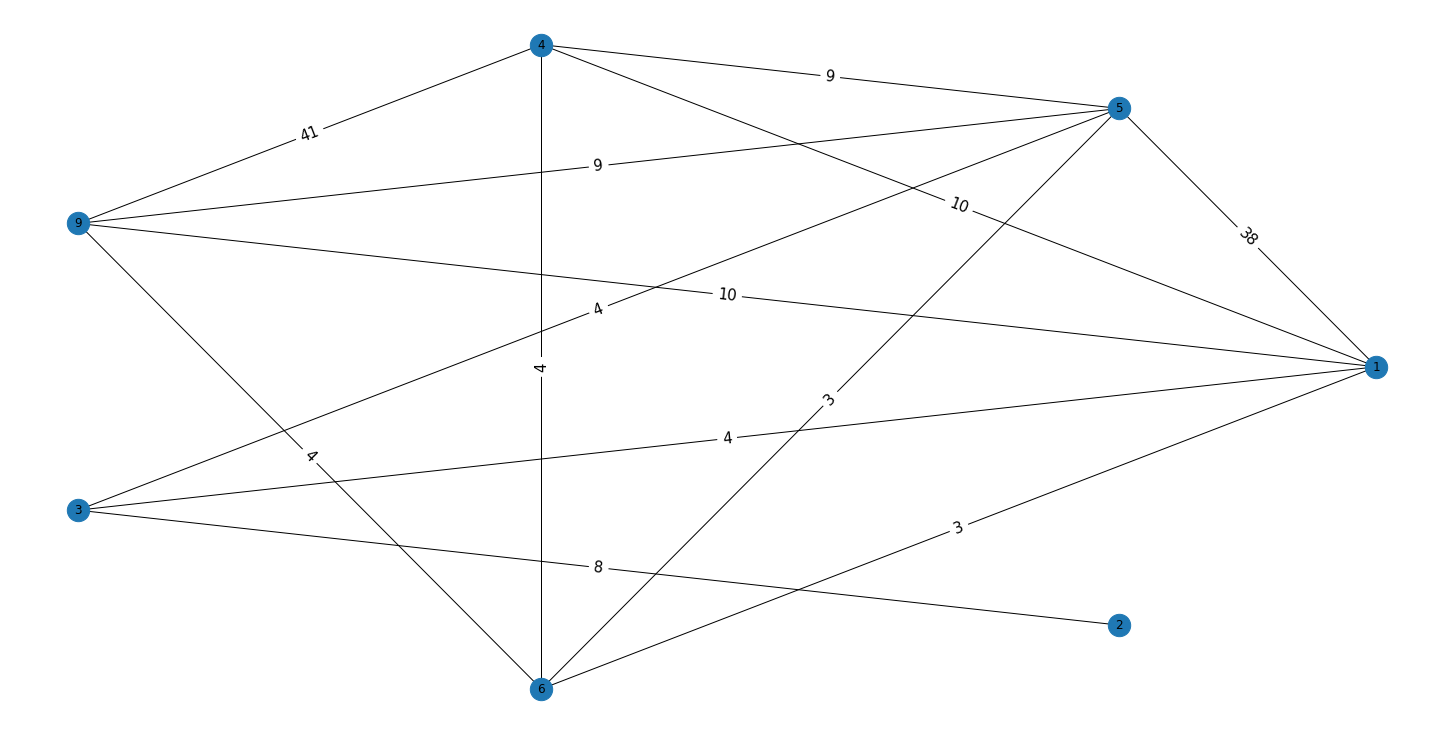

In [12]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9,
         layout='circular',
         min_label=3)

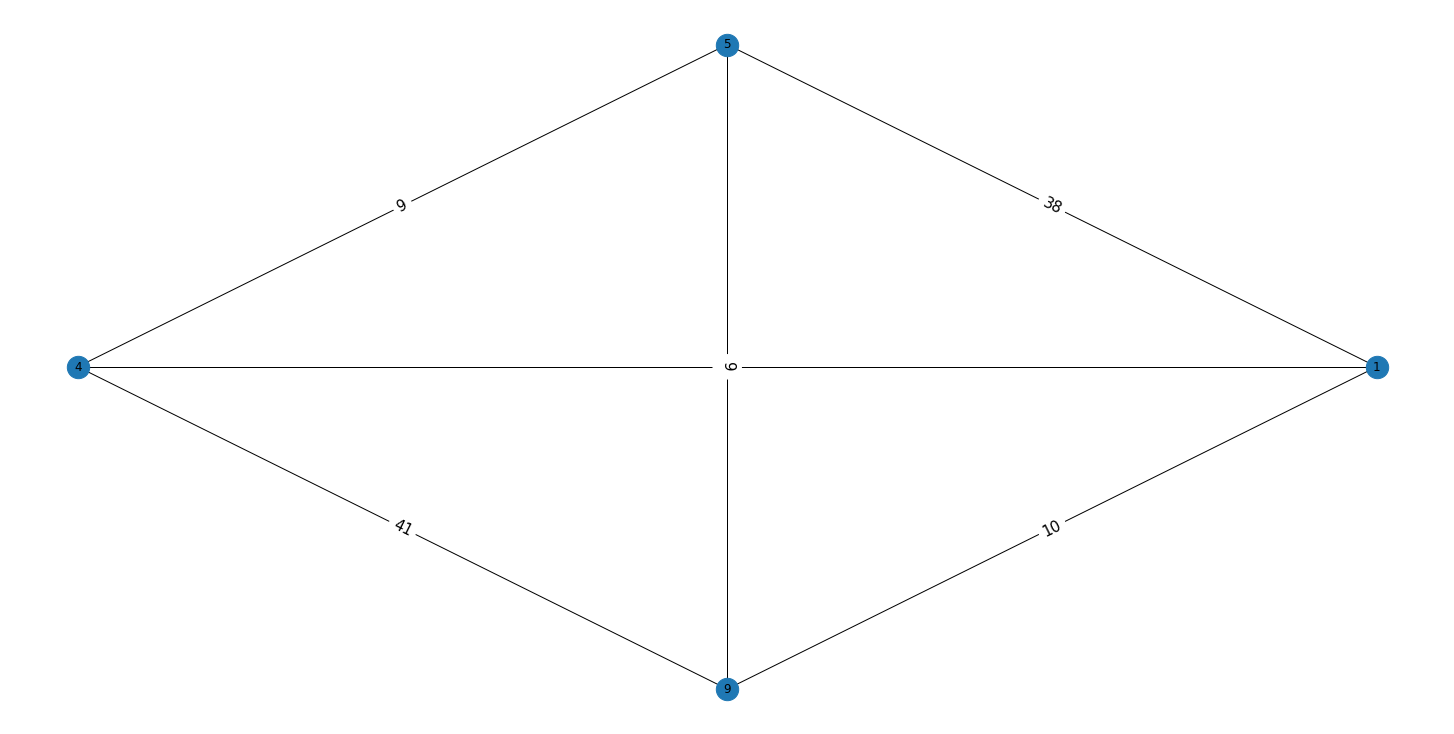

In [13]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9,
         layout='circular',
         min_label=9)

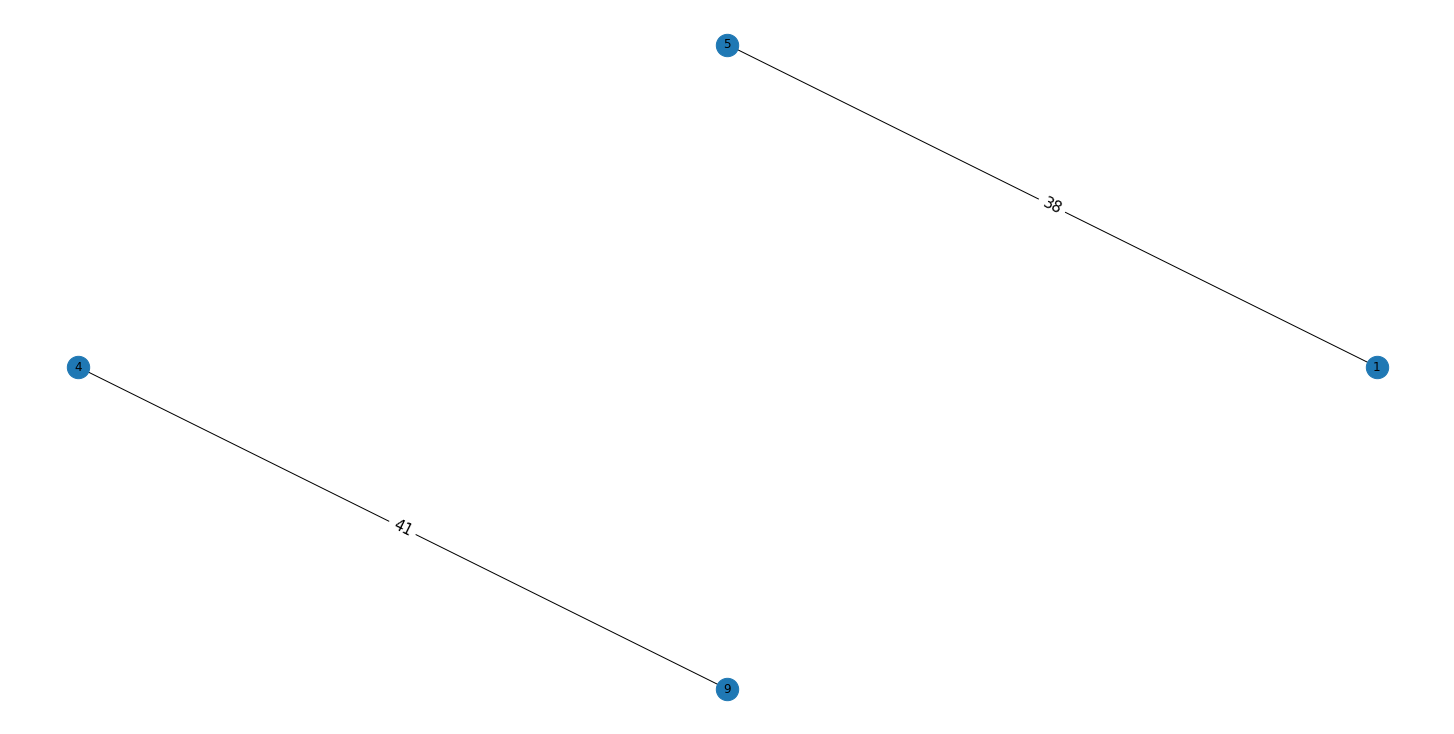

In [14]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9,
         layout='circular',
         min_label=20)

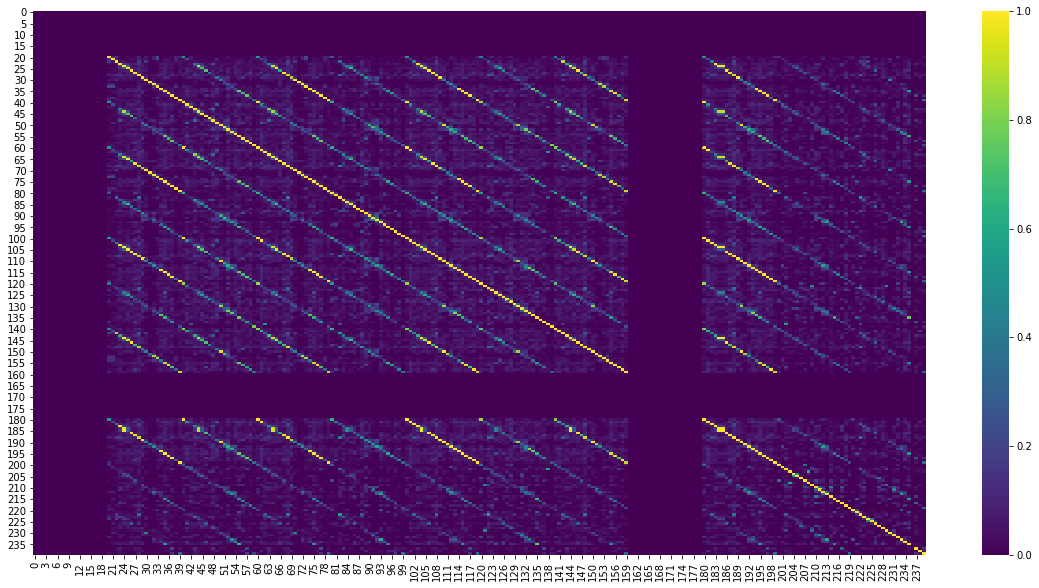

In [15]:
data_dict = preprocess("Dados - ED08.csv")
model_dict = tfidf(data_dict)
sns.heatmap(get_dataplot(data_dict, model_dict), cmap='viridis')

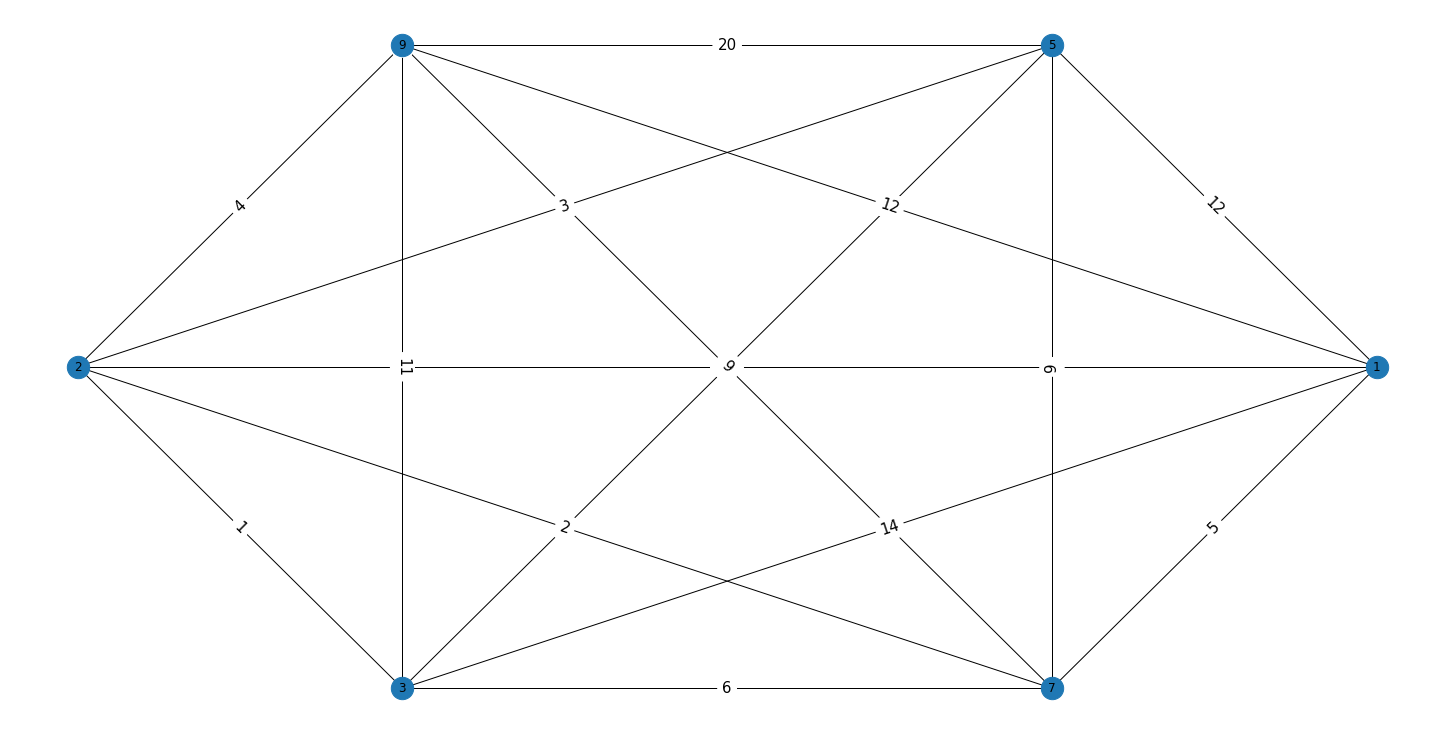

In [16]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9,
         layout='circular')

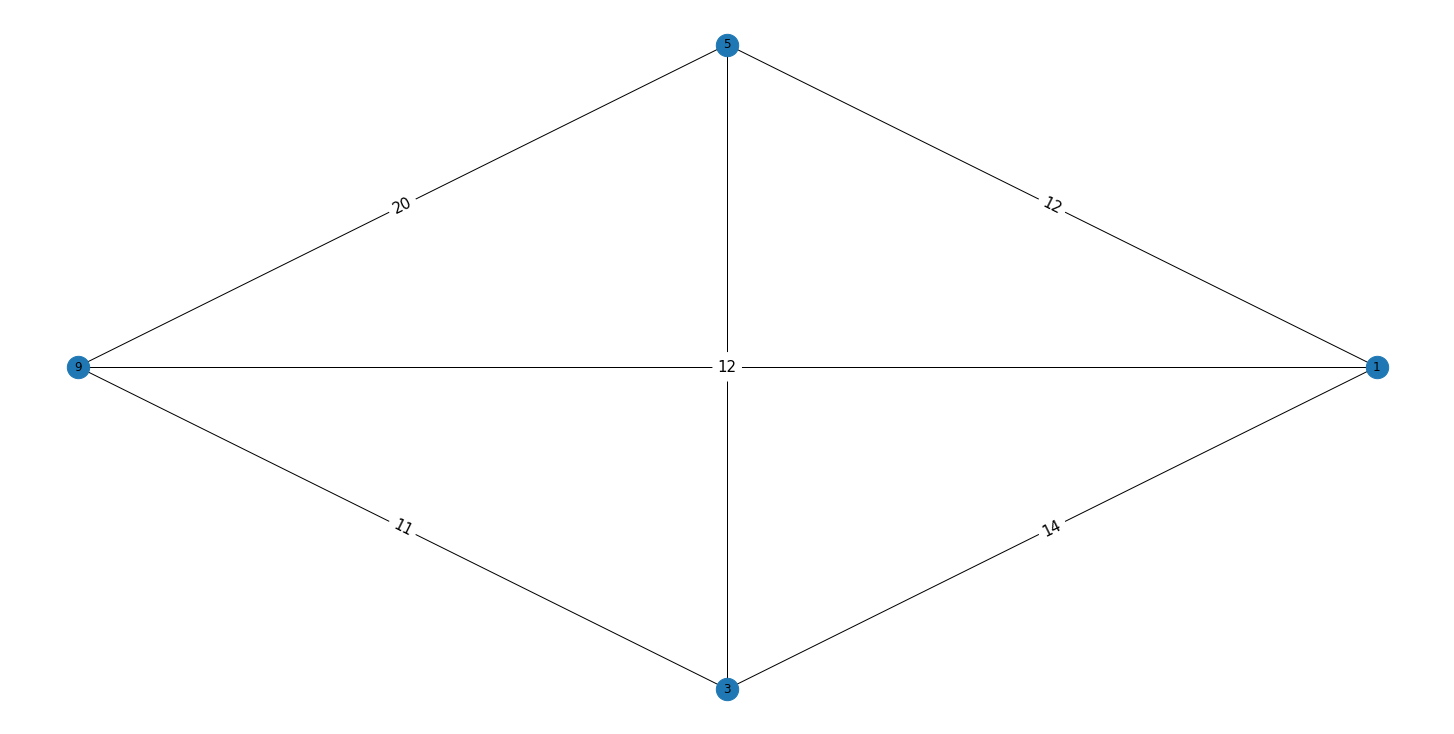

In [17]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9,
         layout='circular',
         min_label=11)

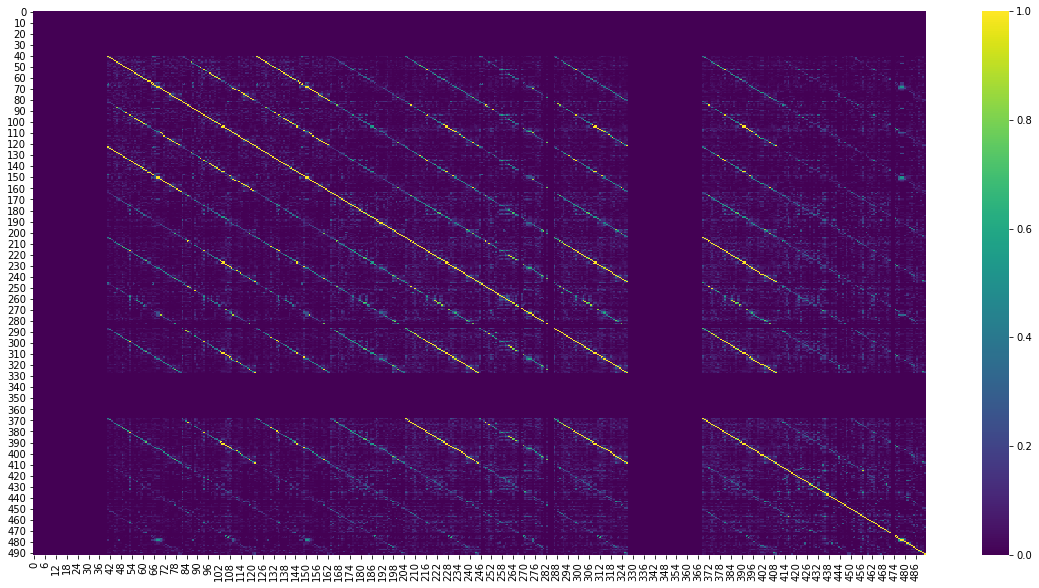

In [18]:
data_dict = preprocess("Dados- ED09.csv")
model_dict = tfidf(data_dict)
sns.heatmap(get_dataplot(data_dict, model_dict), cmap='viridis')

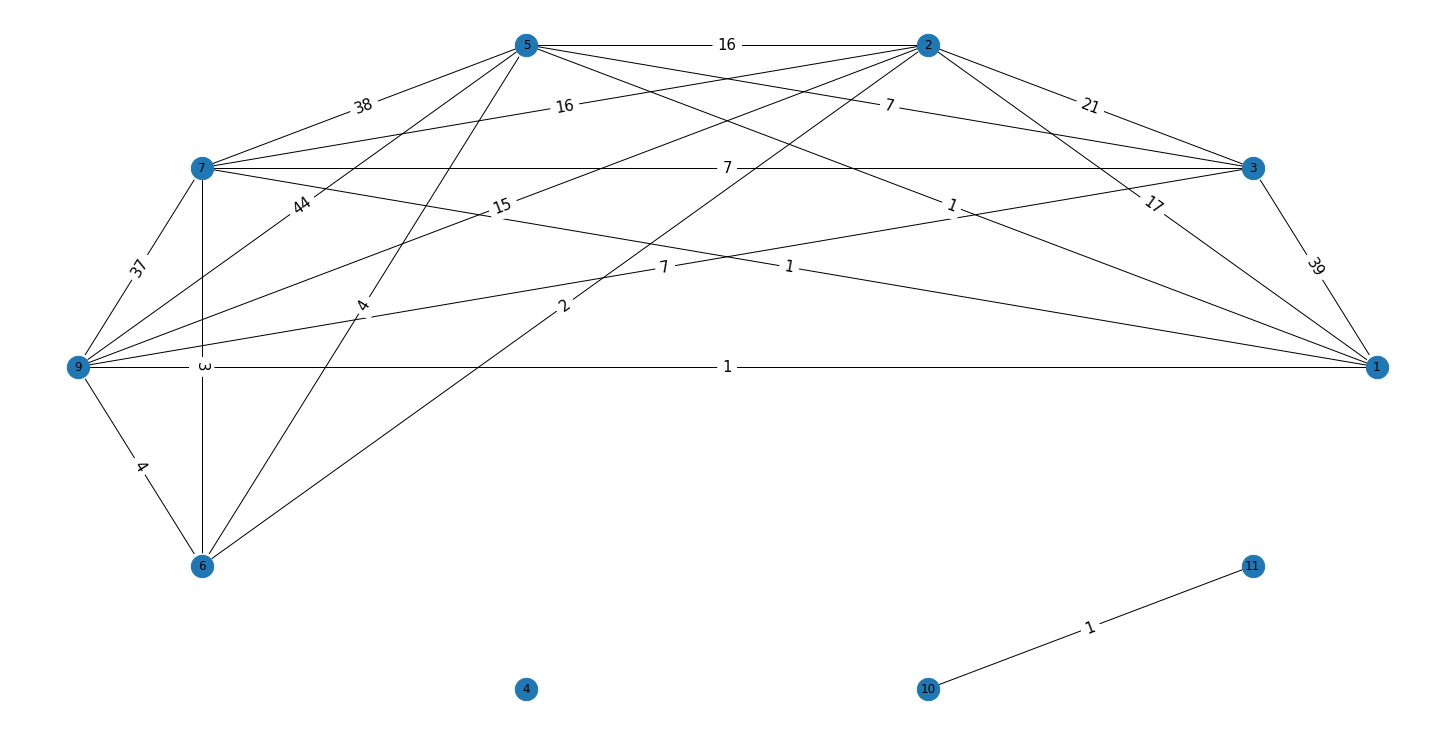

In [19]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9,
         layout='circular')

In [20]:
pd.set_option('display.max_colwidth', -1)
source = "Dados- ED09.csv"
pd.read_csv(source, sep=";").iloc[[1,9]]

,Resposta 1,Resposta 2,Resposta 3,Resposta 4,Resposta 5,Resposta 6,Resposta 7,Resposta 8,Resposta 9,Resposta 10,...,Resposta 32,Resposta 33,Resposta 34,Resposta 35,Resposta 36,Resposta 37,Resposta 38,Resposta 39,Resposta 40,Resposta 41
1,"AS LÍNGUAS NATURAIS SÃO AS LÍNGUAS USADAS PELOS HUMANOS PARA COMUNICAÇÃO (ENTRE OUTRAS FUNÇÕES). ELES SÃO DISTINTAMENTE DIFERENTES DAS LINGUAGENS FORMAIS, COMO C ++, JAVA E PROLOG. UMA DAS PRINCIPAIS DIFERENÇAS, É QUE AS LÍNGUAS NATURAIS SÃO AMBÍGUAS, O QUE SIGNIFICA QUE UMA DETERMINADA SENTENÇA PODE TER MAIS DE UM SIGNIFICADO POSSÍVEL E, EM ALGUNS CASOS, O SIGNIFICADO CORRETO PODE SER MUITO DIFÍCIL DE DETERMINAR. AS LINGUAGENS FORMAIS SÃO QUASE SEMPRE PROJETADAS PARA GARANTIR QUE A AMBIGÜIDADE NÃO POSSA OCORRER. PORTANTO, UM DETERMINADO PROGRAMA ESCRITO EM C ++ PODE TER APENAS UMA INTERPRETAÇÃO. ISTO É CLARAMENTE DESEJÁVEL PORQUE, CASO CONTRÁRIO, O COMPUTADOR TERIA QUE TOMAR UMA DECISÃO ARBITRÁRIA SOBRE QUAL INTERPRETAÇÃO TRABALHAR.","LÍNGUAS COMO CHINÊS, FINLANDÊS E NAVAJO NÃO TÊM QUASE NADA EM COMUM COM O INGLÊS (EMBORA, É CLARO, O FINLANDÊS USE O MESMO ALFABETO). ASSIM, UM SISTEMA QUE PODE TRABALHAR COM UMA LINGUAGEM HUMANA NÃO PODE NECESSARIAMENTE LIDAR COM QUALQUER OUTRA LINGUAGEM HUMANA.","É UMA COLEÇÃO DE TÉCNICAS USADAS PARA PERMITIR QUE OS COMPUTADORES “ENTENDAM” A LINGUAGEM HUMANA. EM GERAL, ELES ESTÃO PREOCUPADOS EM EXTRAIR INFORMAÇÕES GRAMATICAIS E SIGNIFICADOS DE EXPRESSÕES HUMANAS, MAS ELES TAMBÉM ESTÃO PREOCUPADOS EM ENTENDER ESSES ENUNCIADOS E EXECUTAR TAREFAS ÚTEIS COMO RESULTADO.",A FONOLOGIA É O ESTUDO DOS SONS QUE COMPÕEM AS PALAVRAS E É USADO PARA IDENTIFICAR PALAVRAS DE SONS.,"ESTE É O PRIMEIRO ESTÁGIO DE ANÁLISE QUE É APLICADO ÀS PALAVRAS, UMA VEZ QUE ELAS TENHAM SIDO IDENTIFICADAS A PARTIR DA FALA OU INSERIDAS NO SISTEMA. A MORFOLOGIA ANALISA AS MANEIRAS PELAS QUAIS AS PALAVRAS SE DIVIDEM EM COMPONENTES E COMO ISSO AFETA SEU STATUS GRAMATICAL. POR EXEMPLO, A LETRA “S” NO FINAL DE UMA PALAVRA PODE MUITAS VEZES INDICAR QUE É UM SUBSTANTIVO NO PLURAL OU UM VERBO NO TEMPO PRESENTE NA TERCEIRA PESSOA.","ESTA ETAPA ENVOLVE A APLICAÇÃO DAS REGRAS DA GRAMÁTICA DA LINGUAGEM QUE ESTÁ SENDO USADA. A SINTAXE DETERMINA O PAPEL DE CADA PALAVRA EM UMA SENTENÇA E, ASSIM, PERMITE QUE UM SISTEMA DE COMPUTADOR CONVERTA SENTENÇAS EM UMA ESTRUTURA QUE POSSA SER MAIS FACILMENTE MANIPULADA.","ISSO ENVOLVE O EXAME DO SIGNIFICADO DAS PALAVRAS E FRASES. COMO VEREMOS, É POSSÍVEL QUE UMA SENTENÇA ESTEJA SINTATICAMENTE CORRETA, MAS SEM SIGNIFICADO SEMANTICAMENTE. POR OUTRO LADO, É DESEJÁVEL QUE UM SISTEMA DE COMPUTADOR SEJA CAPAZ DE COMPREENDER SENTENÇAS COM SINTAXE INCORRETA, MAS QUE AINDA TRANSMITAM INFORMAÇÕES ÚTEIS SEMANTICAMENTE.","ESTA É A APLICAÇÃO DA COMPREENSÃO HUMANA ÀS FRASES E AO DISCURSO PARA DETERMINAR SIGNIFICADOS QUE NÃO SÃO IMEDIATAMENTE CLAROS A PARTIR DA SEMÂNTICA. POR EXEMPLO, SE ALGUÉM DISSER: ""VOCÊ PODE ME DIZER A HORA?"", A MAIORIA DAS PESSOAS SABE QUE ""SIM"" NÃO É UMA RESPOSTA ADEQUADA. PRAGMÁTICA PERMITE QUE UM SISTEMA DE COMPUTADOR DÊ UMA RESPOSTA SENSATA A QUESTÕES COMO ESTA.","OS SISTEMAS DE PROCESSAMENTO DE LINGUAGEM NATURAL DEVEM APLICAR ALGUM TIPO DE CONHECIMENTO DO MUNDO. NA MAIORIA DOS SISTEMAS DO MUNDO REAL, ESSE CONHECIMENTO MUNDIAL É LIMITADO A UM DOMÍNIO ESPECÍFICO (POR EXEMPLO, UM SISTEMA PODE TER CONHECIMENTO DETALHADO SOBRE O BLOCKS WORLD E SER CAPAZ DE RESPONDER A PERGUNTAS SOBRE ESSE MUNDO). O OBJETIVO FINAL DO PROCESSAMENTO DA LINGUAGEM NATURAL SERIA TER UM SISTEMA COM CONHECIMENTO MUNDIAL SUFICIENTE PARA ENVOLVER UM HUMANO NA DISCUSSÃO SOBRE QUALQUER ASSUNTO. ESTE OBJETIVO AINDA ESTÁ MUITO LONGE.","A ANÁLISE MORFOLÓGICA É ÚTIL PRINCIPALMENTE NO PROCESSAMENTO DE LINGUAGEM NATURAL PARA IDENTIFICAR PARTES DA FALA (SUBSTANTIVOS, VERBOS, ETC.) E PARA IDENTIFICAR QUAIS PALAVRAS PERTENCEM JUNTAS. EM INGLÊS, A ORDEM DAS PALAVRAS TENDE A FORNECER MAIS DESSAS INFORMAÇÕES DO QUE A MORFOLOGIA. EM LÍNGUAS COMO O LATIM, A ORDEM DAS PALAVRAS ERA QUASE INTEIRAMENTE S

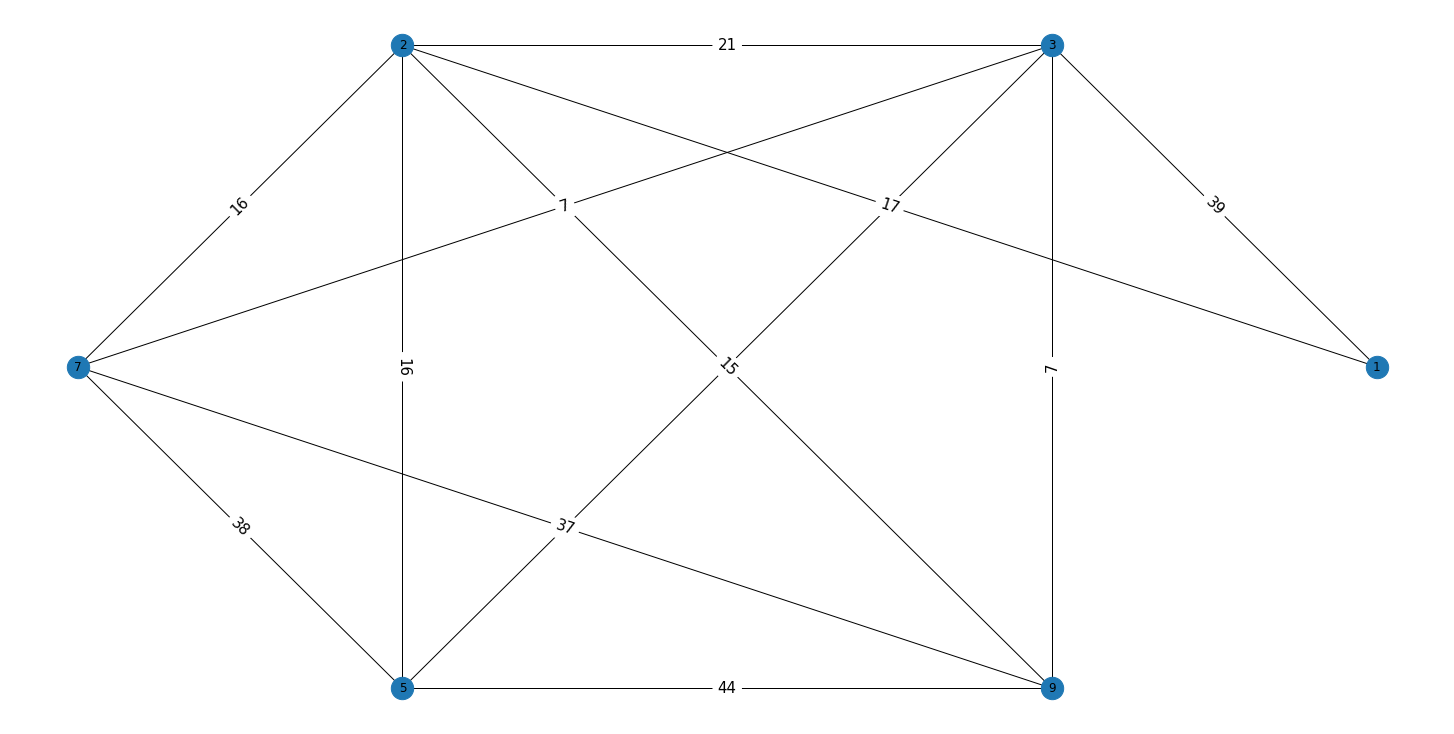

In [21]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9,
         layout='circular',
         min_label=7)

In [22]:
pd.set_option('display.max_colwidth', -1)
source = "Dados- ED09.csv"
pd.read_csv(source, sep=";").dropna().iloc[[1, 6]].transpose()

,2,9
Resposta 1,"As linguagens naturais são as linguagens utilizadas pelos seres humanos para comunicação, a principal diferença das linguagens naturais e linguagens formais é a ambiguidade. As linguagens naturais são ambíguas de forma que uma sentença pode ter mais de um significado possível e nas linguagens formais temos que as mesmas são projetadas para evitar ao máximo a ambiguidade.","As línguas naturais são as línguas usadas pelos humanos para comunicação (entre outras funções). Eles são distintamente diferentes das linguagens formais, como C ++, Java e PROLOG. Uma das principais diferenças, é que as línguas naturais são ambíguas, o que significa que uma determinada sentença pode ter mais de um significado possível e, em alguns casos, o significado correto pode ser muito difícil de determinar. As linguagens formais são quase sempre projetadas para garantir que a ambigüidade não possa ocorrer. Portanto, um determinado programa escrito em C ++ pode ter apenas uma interpretação. Isto é claramente desejável porque, caso contrário, o computador teria que tomar uma decisão arbitrária sobre qual interpretação trabalhar."
Resposta 2,DEVIDO A GRANDE DIFERENÇA QUE EXISTE ENTRE ENTRE DETERMINADAS LINGUAGENS NATURAIS TORNA-SE O SISTEMA PARA UMA DETERMINADA LINGUAGEM NÃO NECESSARIAMENTE FUNCIONAL PARA OUTRA.,"Línguas como chinês, finlandês e navajo não têm quase nada em comum com o inglês (embora, é claro, o finlandês use o mesmo alfabeto). Assim, um sistema que pode trabalhar com uma linguagem humana não pode necessariamente lidar com qualquer outra linguagem humana."
Resposta 3,Uma coleção de técnicas usadas para que os computadores “entendam” a linguagem natural (humana).,"É uma coleção de técnicas usadas para permitir que os computadores “entendam” a linguagem humana. Em geral, eles estão preocupados em extrair informações gramaticais e significados de expressões humanas, mas eles também estão preocupados em entender esses enunciados e executar tarefas úteis como resultado."
Resposta 4,A fonologia é o estudo dos sons que compõem as palavras e é usado para identificar palavras de sons.,A fonologia é o estudo dos sons que compõem as palavras e é usado para identificar palavras de sons.
Resposta 5,"A morfologia é o estudo a respeito da estrutura, da formação e classificação das palavras. O objetivo da morfologia é estudar as palavras isoladas. Podemos dizer que a morfologia é o estudo da estrutura e da formação das palavras.","Este é o primeiro estágio de análise que é aplicado às palavras, uma vez que elas tenham sido identificadas a partir da fala ou inseridas no sistema. A morfologia analisa as maneiras pelas quais as palavras se dividem em componentes e como isso afeta seu status gramatical. Por exemplo, a letra “s” no final de uma palavra pode muitas vezes indicar que é um substantivo no plural ou um verbo no tempo presente na terceira pessoa."
Resposta 6,"A SINTAXE DETERMINA O PAPEL DE CADA PALAVRA EM UMA SENTENÇA E, ASSIM, PERMITE QUE UM SISTEMA DE COMPUTADOR CONVERTA SENTENÇAS EM UMA ESTRUTURA QUE POSSA SER MAIS FACILMENTE MANIPULADA.","Esta etapa envolve a aplicação das regras da gramática da linguagem que está sendo usada. A sintaxe determina o papel de cada palavra em uma sentença e, assim, permite que um sistema de computador converta sentenças em uma estrutura que possa ser mais facilmente manipulada."
Resposta 7,A SEMÂNTICA ENVOLVE O SIGNIFICADO DAS PALAVRAS E FRASES. É O ESTUDO DO SIGNIFICADO QUE AS PALAVRAS E FRASES POSSUEM.,"Isso envolve o exame do significado das palavras e frases. Como veremos, é possível que uma sentença esteja sintaticamente correta, mas sem significado semanticamente. Por outro lado, é desejável que um sistema de computador seja capaz de compreender sentenças com sintaxe incorreta, mas que ainda transmitam informações úteis semanticamente."
Resposta 8,Esta é a aplicação da compreensão humana às frases e ao discurso para determinar significados que não são imediatamente claros a partir da semânt

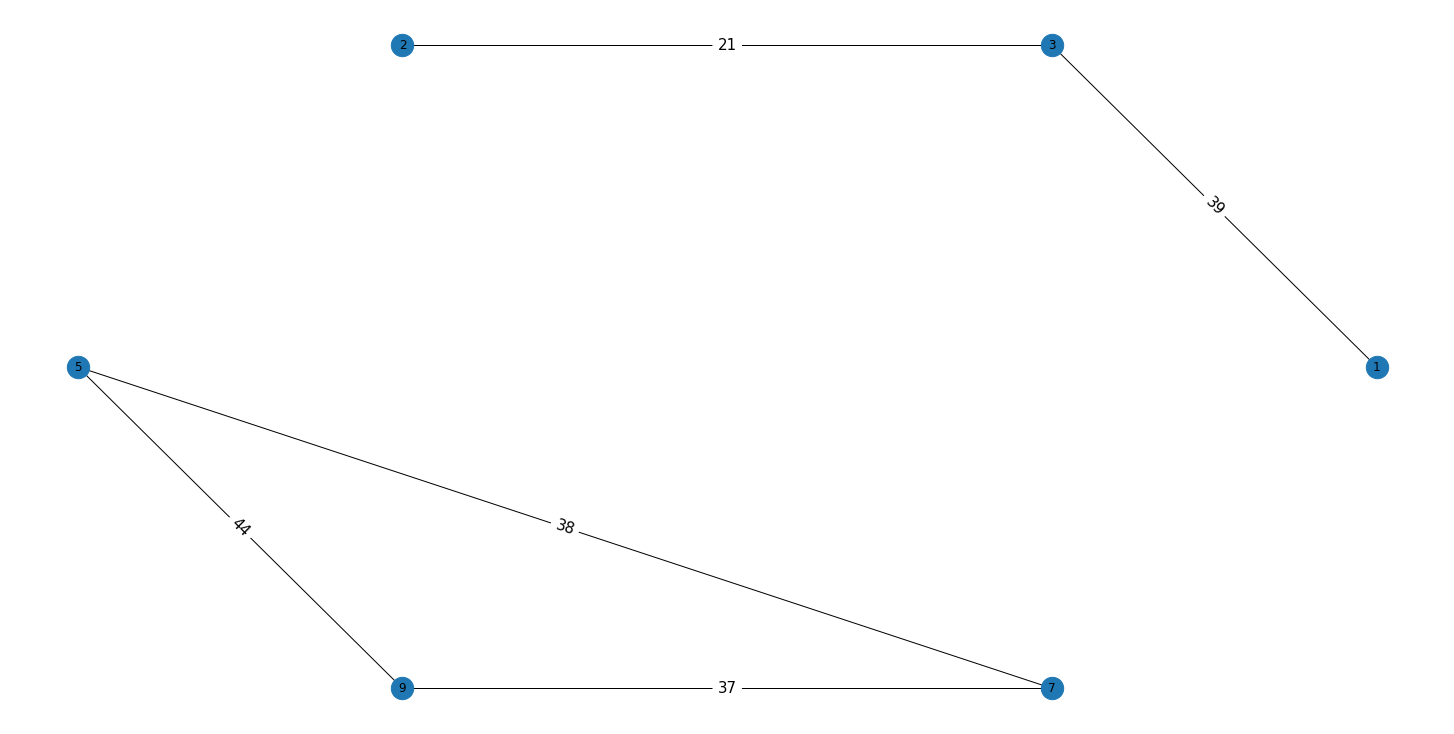

In [23]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9,
         layout='circular',
         min_label=20)

In [24]:
pd.set_option('display.max_colwidth', -1)
source = "Dados- ED09.csv"
pd.read_csv(source, sep=";").dropna().iloc[[4, 6]].transpose()

,5,9
Resposta 1,"As línguas naturais são as línguas usadas pelos humanos para comunicação (entre outras funções). Eles são distintamente diferentes das linguagens formais, como C ++, Java e PROLOG. Uma das principais diferenças, é que as línguas naturais são ambíguas, o que significa que uma determinada sentença pode ter mais de um significado possível e, em alguns casos, o significado correto pode ser muito difícil de determinar. As linguagens formais são quase sempre projetadas para garantir que a ambigüidade não possa ocorrer. Portanto, um determinado programa escrito em C ++ pode ter apenas uma interpretação. Isto é claramente desejável porque, caso contrário, o computador teria que tomar uma decisão arbitrária sobre qual interpretação trabalhar.","As línguas naturais são as línguas usadas pelos humanos para comunicação (entre outras funções). Eles são distintamente diferentes das linguagens formais, como C ++, Java e PROLOG. Uma das principais diferenças, é que as línguas naturais são ambíguas, o que significa que uma determinada sentença pode ter mais de um significado possível e, em alguns casos, o significado correto pode ser muito difícil de determinar. As linguagens formais são quase sempre projetadas para garantir que a ambigüidade não possa ocorrer. Portanto, um determinado programa escrito em C ++ pode ter apenas uma interpretação. Isto é claramente desejável porque, caso contrário, o computador teria que tomar uma decisão arbitrária sobre qual interpretação trabalhar."
Resposta 2,"Línguas como chinês, finlandês e navajo não têm quase nada em comum com o inglês (embora, é claro, o finlandês use o mesmo alfabeto). Assim, um sistema que pode trabalhar com uma linguagem humana não pode necessariamente lidar com qualquer outra linguagem humana.","Línguas como chinês, finlandês e navajo não têm quase nada em comum com o inglês (embora, é claro, o finlandês use o mesmo alfabeto). Assim, um sistema que pode trabalhar com uma linguagem humana não pode necessariamente lidar com qualquer outra linguagem humana."
Resposta 3,"É uma coleção de técnicas usadas para permitir que os computadores “entendam” a linguagem humana. Em geral, eles estão preocupados em extrair informações gramaticais e significados de expressões humanas, mas eles também estão preocupados em entender esses enunciados e executar tarefas úteis como resultado.","É uma coleção de técnicas usadas para permitir que os computadores “entendam” a linguagem humana. Em geral, eles estão preocupados em extrair informações gramaticais e significados de expressões humanas, mas eles também estão preocupados em entender esses enunciados e executar tarefas úteis como resultado."
Resposta 4,A fonologia é o estudo dos sons que compõem as palavras e é usado para identificar palavras de sons.,A fonologia é o estudo dos sons que compõem as palavras e é usado para identificar palavras de sons.
Resposta 5,"Este é o primeiro estágio de análise que é aplicado às palavras, uma vez que elas tenham sido identificadas a partir da fala ou inseridas no sistema. A morfologia analisa as maneiras pelas quais as palavras se dividem em componentes e como isso afeta seu status gramatical. Por exemplo, a letra “s” no final de uma palavra pode muitas vezes indicar que é um substantivo no plural ou um verbo no tempo presente na terceira pessoa.","Este é o primeiro estágio de análise que é aplicado às palavras, uma vez que elas tenham sido identificadas a partir da fala ou inseridas no sistema. A morfologia analisa as maneiras pelas quais as palavras se dividem em componentes e como isso afeta seu status gramatical. Por exemplo, a letra “s” no final de uma palavra pode muitas vezes indicar que é um substantivo no plural ou um verbo no tempo presente na terceira pessoa."
Resposta 6,"Esta etapa envolve a aplicação das regras da gramática da linguagem que está sendo usada. A sintaxe determina o papel de cada palavra em uma sentença e, assim, permite que um sistema de computador converta sentenças em